In [ ]:
import gc
import re
import json
import random
from itertools import chain
from tqdm.auto import tqdm
import difflib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageEnhance
import cv2

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, Dataset, SequentialSampler, RandomSampler

from torchvision.transforms import v2
import albumentations as A

from torchmetrics.text import CharErrorRate, WordErrorRate
from torchmetrics.functional.text import char_error_rate, word_error_rate
import Levenshtein

from doctr.io import DocumentFile
from doctr.models import ocr_predictor, recognition, detection
from doctr.transforms import Resize
from doctr.datasets import WordGenerator, RecognitionDataset

from doctr.datasets import DetectionDataset
from doctr import transforms as T
from doctr.utils.metrics import LocalizationConfusion
from doctr.models.preprocessor import PreProcessor

from castom_utils import *

In [ ]:
SEED = 42

IS_CUDA = torch.cuda.is_available()
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f'torch use: {Ansi.green}{Ansi.bold}{DEVICE}{Ansi.end}', 
      f'({torch.cuda.get_device_name()})' 
      if torch.cuda.is_available() else '')

In [1]:
CFG = load_config()

NameError: name 'load_config' is not defined

## Detection model

### dataset

In [14]:
detection_dataset = PATH_DATASET.joinpath('detection')

In [15]:
img_transforms = v2.Compose([
    T.RandomApply(T.ColorInversion(), p=.1),
    T.RandomApply(T.RandomShadow(), p=.3),
    T.RandomApply(v2.GaussianBlur(kernel_size=5, sigma=(.1, .4)), p=.3),
    T.RandomApply(T.GaussianNoise(0, .1), p=.3),
    v2.RandomGrayscale(p=.2),
    v2.RandomPhotometricDistort(p=.2),
])


sample_transforms_train = T.SampleCompose([
    # T.RandomHorizontalFlip(0.15),
    T.OneOf([
        T.RandomApply(T.RandomCrop(ratio=(0.6, 1.33)), 0.25),
        T.RandomResize(scale_range=(0.4, 0.9), preserve_aspect_ratio=0.5, symmetric_pad=0.5, p=0.25),
    ]),
    # Rotation augmentation
    T.Resize(1024, preserve_aspect_ratio=True),
    T.RandomApply(T.RandomRotate(1.5, expand=True), 0.5),
    T.Resize((1024, 1024), preserve_aspect_ratio=True, symmetric_pad=True),
    v2.Normalize(mean=(0.798, 0.785, 0.772), std=(0.264, 0.2749, 0.287)),
])



sample_transforms_val = T.SampleCompose([
    T.Resize(1024, preserve_aspect_ratio=True),
    T.RandomApply(T.RandomRotate(90, expand=True), 0.5),
    T.Resize((1024, 1024), preserve_aspect_ratio=True, symmetric_pad=True),
    v2.Normalize(mean=(0.798, 0.785, 0.772), std=(0.264, 0.2749, 0.287)),

])

In [16]:
train_set_d = DetectionDataset(
    detection_dataset.joinpath('train', 'images'), 
    detection_dataset.joinpath('train', 'labels.json'), 
    img_transforms=img_transforms,
    sample_transforms=sample_transforms_train,
    use_polygons=True
)

val_set_d = DetectionDataset(
    detection_dataset.joinpath('val', 'images'), 
    detection_dataset.joinpath('val', 'labels.json'), 
    # img_transforms=img_transforms,
    sample_transforms=sample_transforms_val,
    use_polygons=True
)

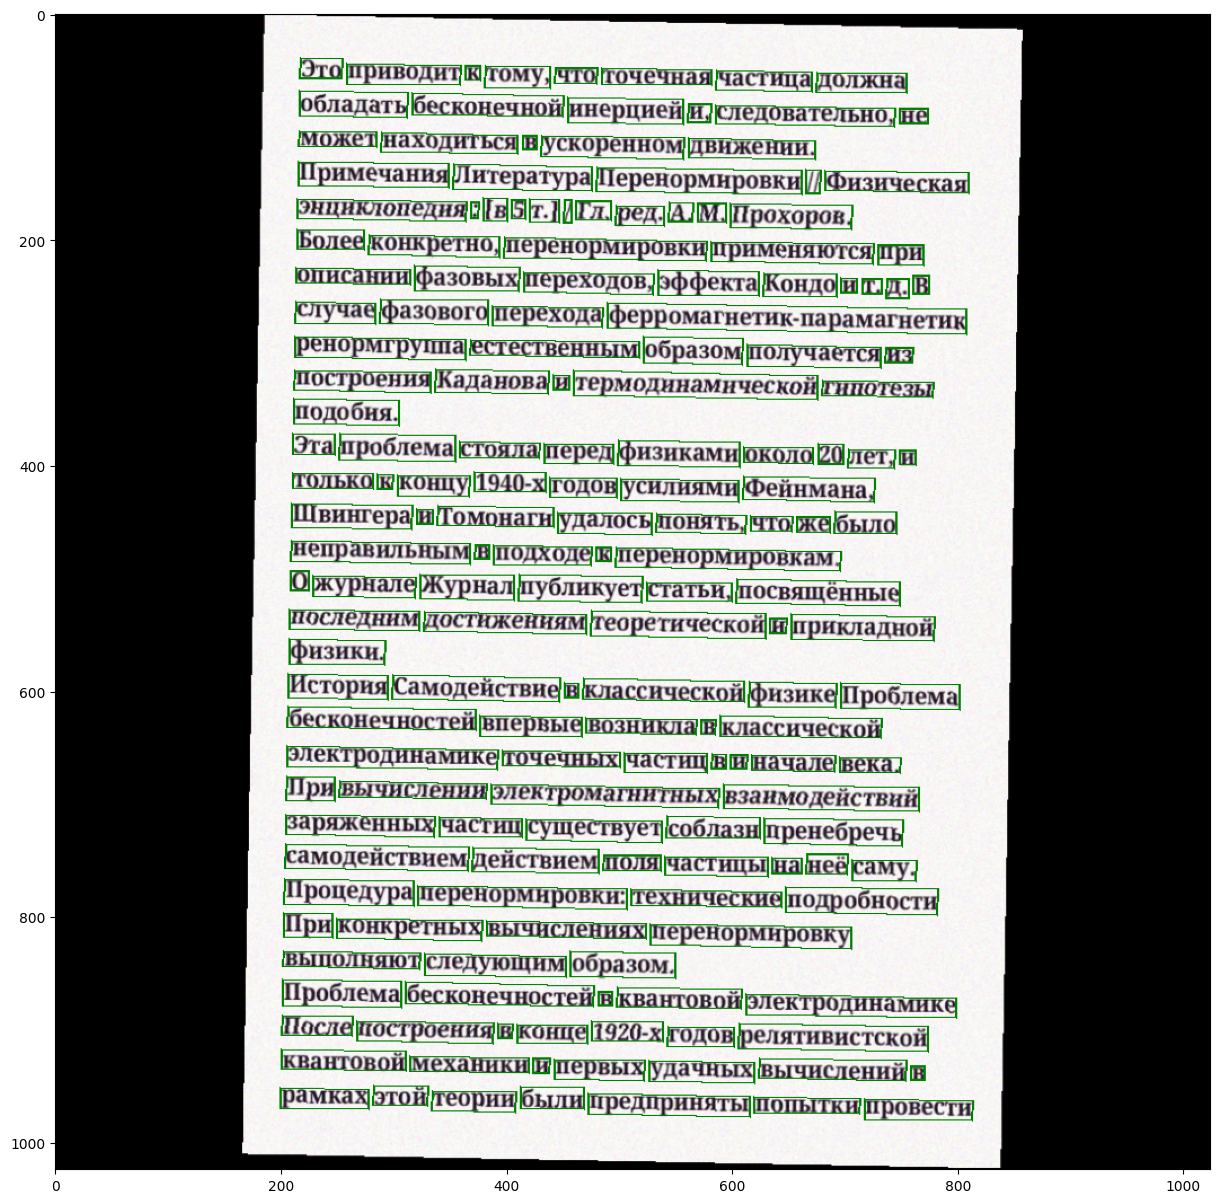

In [17]:
denorm = DeNormalize(mean=(0.798, 0.785, 0.772), std=(0.264, 0.2749, 0.287))

set_sample = train_set_d[0]

img, target = set_sample

height, width = img.shape[1:]
boxes = (target['words'] * np.array([width, height])).astype(np.int32)

# img = (img * 255).to(torch.uint8)
img = (denorm(img) * 255).to(torch.uint8)
img = img.numpy().transpose(1, 2, 0)

img = Image.fromarray(img)
draw = ImageDraw.Draw(img)

for bbox in boxes:
    draw.polygon([tuple(cord) for cord in bbox], outline='green', width=2)
plt.figure(figsize=(15, 15))
plt.imshow(img)
plt.show()

In [23]:
BATCH_SIZE = 8

train_loader_d = DataLoader(train_set_d, batch_size=BATCH_SIZE, shuffle=True, collate_fn=train_set_d.collate_fn)
val_loader_d = DataLoader(val_set_d, batch_size=BATCH_SIZE, shuffle=False, collate_fn=val_set_d.collate_fn)

In [74]:
model_detection = detection.linknet_resnet18(pretrained=True).to(DEVICE)

In [75]:
load_state = torch.load('models_doctr/last_detection.pth', map_location=DEVICE, weights_only=True)

In [76]:
model_detection.load_state_dict(load_state['model'])
# optimizer.load_state_dict(load_state['optimizer'])
# scheduler.load_state_dict(load_state['scheduler'])

<All keys matched successfully>

In [20]:
parameters = [p for p in model_detection.parameters() if p.requires_grad]
optimizer = optim.Adam(parameters, lr=8e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=.5)

In [104]:
gc.collect()
torch.cuda.empty_cache()

EPOCHS = 3

for epoch in range(EPOCHS):
    train_loss, val_loss = [], []
    last_lr = scheduler.get_last_lr()[0]

    # TRAIN
    model_detection.train()
    loop = tqdm(train_loader_d, leave=False)
    for images, targets in loop:
        images = images.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model_detection(images, targets)
        loss = outputs['loss']
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_recognition.parameters(), 5)
        optimizer.step()

        train_loss.append(loss.detach().item())
        loop_description = f'Epoch [{epoch + 1}/{EPOCHS}], lr: {last_lr:.1e}, loss: {np.mean(train_loss):.4f}'
        loop.set_description(loop_description)

    # VALID
    model_detection.eval()
    val_metric.reset()

    with torch.no_grad():
        for images, targets in tqdm(val_loader_d, desc='evaluation', leave=False):
            images = images.to(DEVICE)
            outputs = model_detection(images, targets, return_preds=True)
            loss = outputs['loss']
            # loc_preds = outputs["preds"]
    
        val_loss.append(loss.item())

    val_loss = np.mean(val_loss)

    # Вывод результатов обучения для эпохи
    print(
        loop_description, 
        f"| val loss: {Ansi.bold}{val_loss:.4f}{Ansi.end}",
        # f"recall: {Ansi.bold}{recall:.4f}{Ansi.end}",
        # f"precision: {Ansi.bold}{precision:.4f}{Ansi.end}",
        # f"mean_iou: {Ansi.bold}{mean_iou:.4f}{Ansi.end}",
        end = ' '
    )

    # Scheduler step
    scheduler.step()


    # Save last model
    save_model(model_detection, optimizer, scheduler, 'last_detection')

NameError: name 'train_loader_d' is not defined

In [26]:
set_sample = val_set_d[0]

model_detection.eval()
with torch.no_grad():
    image, target = set_sample
    image = image.to(DEVICE).unsqueeze(0)
    output = model_detection(image, [target], return_preds=True)

    boxes = output['preds'][0]['words'][:, :4]
    loss = output['loss'].item()

    height, width = image.shape[2:]
    boxes = (boxes * np.array([width, height, width, height])).astype(np.int32)

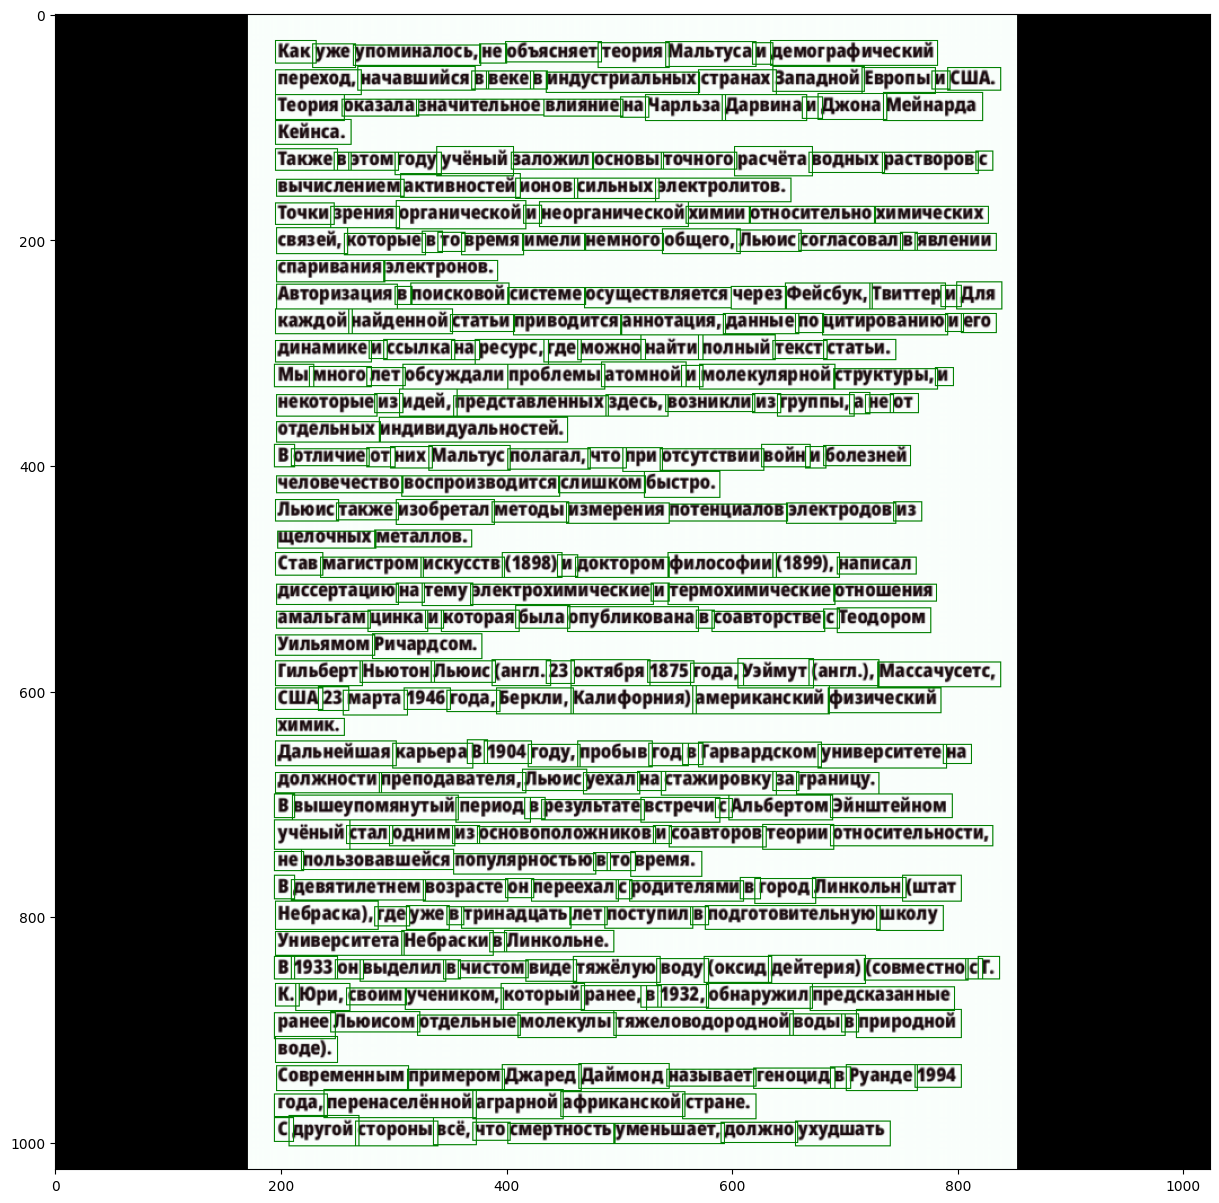

In [27]:
img = (denorm(image) * 255).cpu().to(torch.uint8).squeeze().numpy().transpose(1, 2, 0)
img = Image.fromarray(img)
draw = ImageDraw.Draw(img)

for bbox in boxes:
    draw.rectangle(bbox.tolist(), outline='green', width=1)

plt.figure(figsize=(15, 15))
plt.imshow(img)
plt.show()

In [28]:
print(result.render())

NameError: name 'result' is not defined